In [4]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")
import numpy as np
import os
try: os.mkdir("figures")
except FileExistsError: pass

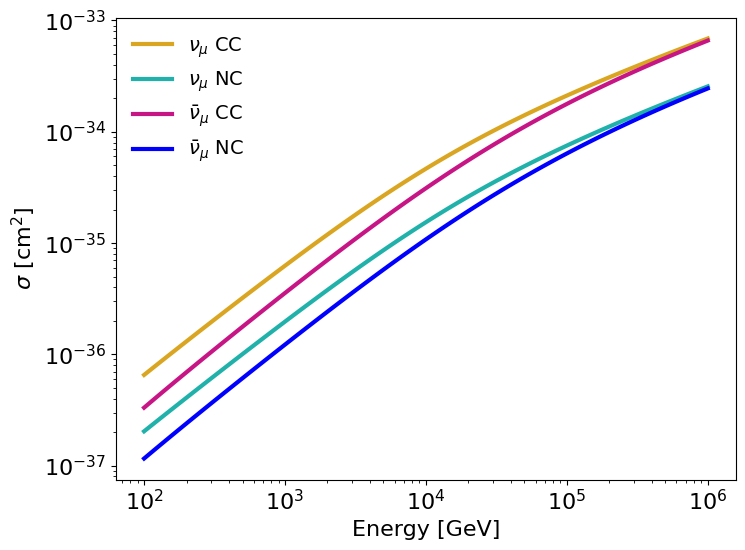

In [135]:
import siren
from siren.SIREN_Controller import SIREN_Controller

# Number of events to inject
events_to_inject = int(1e5)
# Expeirment to run
experiment = "IceCube"

# Define the controller
controllers = {k:SIREN_Controller(events_to_inject, experiment) for k in ["CC_numu",
                                                                         "NC_numu",
                                                                         "CC_numubar",
                                                                         "NC_numubar"]}

# Particle to inject
numu = siren.dataclasses.Particle.ParticleType.NuMu
numubar = siren.dataclasses.Particle.ParticleType.NuMuBar

# target mass
target_mass = 0.5 * (0.938272 + 0.939565)

cross_section_model = "CSMSDISSplines"

xsfiledir = siren.utilities.get_cross_section_model_path(cross_section_model)

# Cross Section Model
target_type = siren.dataclasses.Particle.ParticleType.Nucleon

DIS_xs_CC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_CC_iso.fits"),
    1, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [numu], # primary types
    [target_type], "m"
)

DIS_xs_NC = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nu_NC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nu_NC_iso.fits"),
    2, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [numu], # primary types
    [target_type], "m"
)

DIS_xs_CCbar = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nubar_CC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nubar_CC_iso.fits"),
    1, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [numubar], # primary types
    [target_type], "m"
)

DIS_xs_NCbar = siren.interactions.DISFromSpline(
    os.path.join(xsfiledir, "dsdxdy_nubar_NC_iso.fits"),
    os.path.join(xsfiledir, "sigma_nubar_NC_iso.fits"),
    2, # interaction type
    target_mass, # taget mass [GeV]
    1., # min Q^2 [GeV^2]
    [numubar], # primary types
    [target_type], "m"
)

erange = np.logspace(2,6,100)
plt.plot(erange,[DIS_xs_CC.TotalCrossSection(numu,e) for e in erange],label=r"$\nu_\mu$ CC")
plt.plot(erange,[DIS_xs_NC.TotalCrossSection(numu,e) for e in erange],label=r"$\nu_\mu$ NC")
plt.plot(erange,[DIS_xs_CCbar.TotalCrossSection(numubar,e) for e in erange],label=r"$\bar{\nu}_\mu$ CC")
plt.plot(erange,[DIS_xs_NCbar.TotalCrossSection(numubar,e) for e in erange],label=r"$\bar{\nu}_\mu$ NC")
plt.loglog()
plt.legend()
plt.xlabel("Energy [GeV]")
plt.ylabel(r"$\sigma~[{\rm cm}^2]$")
plt.show()

primary_xs = {"CC_numu":siren.interactions.InteractionCollection(numu, [DIS_xs_CC]),
              "NC_numu":siren.interactions.InteractionCollection(numu, [DIS_xs_NC]),
              "CC_numubar":siren.interactions.InteractionCollection(numubar, [DIS_xs_CCbar]),
              "NC_numubar":siren.interactions.InteractionCollection(numubar, [DIS_xs_NCbar])}


In [136]:
for key,controller in controllers.items():
    primary_type = numubar if "bar" in key else numu
    controller.SetInteractions(primary_xs[key])

    # Primary distributions
    primary_injection_distributions = {}
    primary_physical_distributions = {}

    mass_dist = siren.distributions.PrimaryMass(0)
    primary_injection_distributions["mass"] = mass_dist
    primary_physical_distributions["mass"] = mass_dist

    # energy distribution
    edist = siren.distributions.PowerLaw(1, 1e2, 1e6)
    primary_injection_distributions["energy"] = edist
    primary_physical_distributions["energy"] = edist

    # direction distribution
    direction_distribution = siren.distributions.IsotropicDirection()
    primary_injection_distributions["direction"] = direction_distribution
    primary_physical_distributions["direction"] = direction_distribution

    # position distribution
    muon_range_func = siren.distributions.LeptonDepthFunction()
    position_distribution = siren.distributions.ColumnDepthPositionDistribution(
        600, 600.0, muon_range_func, set(controller.GetDetectorModelTargets()[0])
    )
    primary_injection_distributions["position"] = position_distribution

    # SetProcesses
    controller.SetProcesses(
        primary_type, primary_injection_distributions, primary_physical_distributions
    )

    controller.Initialize()

    events = controller.GenerateEvents()

    os.makedirs("output", exist_ok=True)

    controller.SaveEvents("output/IceCube_DIS_%s"%key)

In [137]:
data = {}
for key in controllers.keys():
    data[key] = awk.from_parquet("output/IceCube_DIS_%s.parquet"%key)

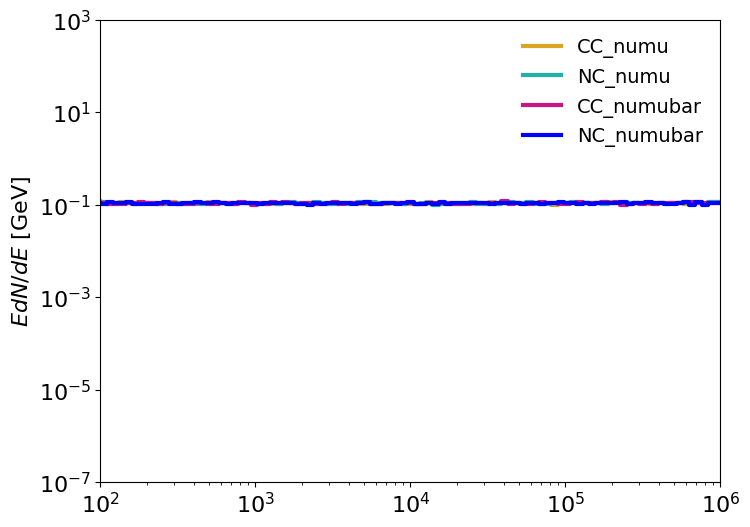

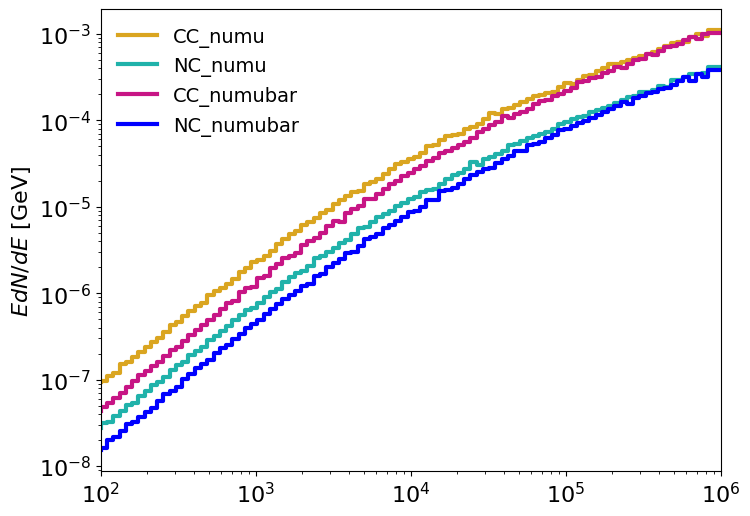

In [138]:
bins = np.logspace(2,6,100)
bw = bins[1:] - bins[:-1]
for k,dataset in data.items():
    nu_energy = np.squeeze(dataset.primary_momentum)[:,0]
    n,_ = np.histogram(nu_energy,weights=nu_energy,bins=bins)
    y = n/bw/events_to_inject
    plt.step(bins,np.append(y,y[-1]),label=k)
plt.xlim(1e2,1e6)
plt.ylim(1e-7,1e3)
plt.loglog()
plt.legend()
plt.ylabel(r"$E dN/dE~{\rm [GeV]}$")
plt.show()

for k,dataset in data.items():
    nu_energy = np.squeeze(dataset.primary_momentum)[:,0]
    n,_ = np.histogram(nu_energy,weights=dataset.event_weight*nu_energy,bins=bins)
    y = n/bw/events_to_inject
    plt.step(bins,np.append(y,y[-1]),label=k)
plt.xlim(1e2,1e6)
#plt.ylim(1e-7,1e3)
plt.loglog()
plt.legend()
plt.ylabel(r"$E dN/dE~{\rm [GeV]}$")
plt.show()